In [1]:
!sudo apt-get install tesseract-ocr
# !pip install torchvision==0.13.1
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install pytesseract
# !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1
!pip install opencv-python-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 4s (1,357 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
!git clone https://github.com/clovaai/CRAFT-pytorch
%cd CRAFT-pytorch

import gdown

# 파일 ID를 사용하여 다운로드 링크 생성
file_id = '1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ'
url = f'https://drive.google.com/uc?id={file_id}'

# 파일 다운로드
output = 'craft_mlt_25k.pth'
gdown.download(url, output, quiet=False)

Cloning into 'CRAFT-pytorch'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59 (from 1)
Receiving objects: 100% (59/59), 1.69 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/CRAFT-pytorch


Downloading...
From: https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
To: /content/CRAFT-pytorch/craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:03<00:00, 26.5MB/s]


'craft_mlt_25k.pth'

In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from craft import CRAFT
from craft_utils import getDetBoxes, adjustResultCoordinates
from imgproc import loadImage, normalizeMeanVariance, resize_aspect_ratio
import pytesseract

In [4]:
# 4. 모델 로드 함수

def load_model():
    model = CRAFT()
    model.load_state_dict(torch.load('craft_mlt_25k.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'), strict=False)
    model.eval()
    return model
# def load_model():
#     model = CRAFT()  # CRAFT 모델 인스턴스 생성
#     model.load_state_dict(torch.load('craft_mlt_25k.pth', map_location='cpu'))
#     model.eval()  # 평가 모드로 설정
#     return model

# 5. 이미지 전처리 함수
# def preprocess_image(image_path):
#     image = loadImage(image_path)
#     img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image, 1280, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5)
#     img_normalized = normalizeMeanVariance(img_resized)
#     img_normalized = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0)
#     return img_normalized, size_heatmap, target_ratio

# def preprocess_image(image_path):
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     _, image_bin = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     image_blurred = cv2.GaussianBlur(image_bin, (5, 5), 0)
#     img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image_blurred, 1280, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5)
#     img_normalized = normalizeMeanVariance(img_resized)
#     img_normalized = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0)
#     return img_normalized, size_heatmap, target_ratio

def preprocess_image(image_path):
    # 이미지를 그레이스케일로 읽기
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # 이진화 적용
    _, image_bin = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # 가우시안 블러 적용
    image_blurred = cv2.GaussianBlur(image_bin, (5, 5), 0)
    # 이미지 크기 조정
    img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image_blurred, 1280, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5)
    # 채널을 추가하여 3채널 이미지로 변환
    if len(img_resized.shape) == 2:  # 흑백 이미지
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

    img_normalized = normalizeMeanVariance(img_resized)
    img_normalized = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0)
    return img_normalized, size_heatmap, target_ratio


# 6. 텍스트 박스 추출 함수 (모델 출력 확인 추가)
# def extract_textboxes(image_path, model):
#     img_normalized, size_heatmap, target_ratio = preprocess_image(image_path)
#     with torch.no_grad():
#         y, feature = model(img_normalized)

#         # 모델 출력 확인
#         print(f"Model output (y): {type(y)}, shape: {y.shape}")
#         print(f"Model output (feature): {type(feature)}, shape: {feature.shape}")

#     # y와 feature가 예상되는 형태인지 확인하고 이후 코드 수정
#     boxes, polys = getDetBoxes(y, 0.7, 0.4, 0.4, True)
#     boxes = adjustResultCoordinates(boxes, target_ratio)
#     return boxes

# 6. 텍스트 박스 추출 함수 (adjustResultCoordinates 수정)
def extract_textboxes(image_path, model):
    img_normalized, size_heatmap, target_ratio = preprocess_image(image_path)
    with torch.no_grad():
        y, _ = model(img_normalized)

    # y 텐서에서 textmap과 linkmap 분리
    y = y.squeeze(0).cpu().numpy()  # (height, width, 2)
    textmap = y[:, :, 0]  # 텍스트 영역 맵
    linkmap = y[:, :, 1]  # 링크 영역 맵

    # # getDetBoxes를 호출할 때 textmap과 linkmap 전달
    # boxes, polys = getDetBoxes(textmap, linkmap, 0.7, 0.4, 0.4, True)
    # 예시: 임계값 조정
    boxes, polys = getDetBoxes(textmap, linkmap, text_threshold=0.6, link_threshold=0.3, low_text=0.2, poly=False)

    # adjustResultCoordinates를 호출할 때, 너비와 높이 비율 모두 전달
    boxes = adjustResultCoordinates(boxes, ratio_w=target_ratio, ratio_h=target_ratio)
    return boxes


# 7. 결과 시각화 함수
def visualize_results(image_path, boxes):
    image = cv2.imread(image_path)
    for box in boxes:
        box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [box], isClosed=True, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


# 8. OCR로 텍스트 추출 함수
def extract_text_from_boxes(image_path, boxes):
    image = cv2.imread(image_path)
    extracted_texts = []
    for box in boxes:
        # 각 박스의 좌표를 사용해 이미지에서 영역을 잘라내기
        pts = np.array(box).reshape((-1, 2))
        rect = cv2.boundingRect(pts)
        x, y, w, h = rect
        cropped_img = image[y:y+h, x:x+w]

        # 잘라낸 이미지에서 텍스트 추출
        text = pytesseract.image_to_string(cropped_img, lang='eng')
        extracted_texts.append(text.strip())

    return extracted_texts

# imgproc.py의 resize_aspect_ratio 함수 수정
def resize_aspect_ratio(img, square_size, interpolation=cv2.INTER_LINEAR, mag_ratio=1):
    if len(img.shape) == 2:  # 흑백 이미지
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    height, width, channel = img.shape

    # 이미지 크기 조정 비율 계산
    img_w = int(width * mag_ratio)
    img_h = int(height * mag_ratio)

    # 크기 조정
    img_resized = cv2.resize(img, (img_w, img_h), interpolation=interpolation)

    # 패딩 추가
    delta_w = max(square_size - img_w, 0)
    delta_h = max(square_size - img_h, 0)

    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left

    # 패딩을 추가하여 이미지 크기 맞추기
    if img_resized.shape[2] == 3:  # 컬러 이미지
        img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(128, 128, 128))
    else:  # 흑백 이미지
        img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=128)

    return img_padded, img_w / width, img_h / height


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


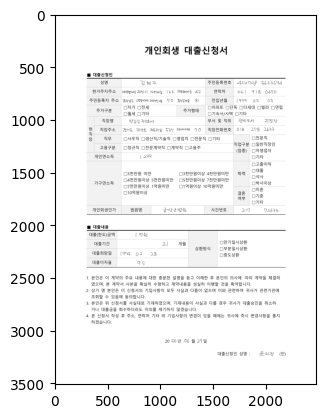

Extracted Texts:


In [5]:
# 9. 메인 실행 부분

# 테스트를 위한 이미지 파일 설정
test_png_file_path = '/content/drive/MyDrive/Colab Notebooks/DL project/data/image/T.Tablet/O.Form/IMG_OCR_53_4TO_03894.png'

# 메인 실행 부분에서 OCR 함수 호출
if __name__ == '__main__':
    model = load_model()
    image_path = test_png_file_path  # 이미지 파일 경로를 지정하세요.
    boxes = extract_textboxes(image_path, model)
    visualize_results(image_path, boxes)  # 시각화
    texts = extract_text_from_boxes(image_path, boxes)  # 텍스트 추출
    print("Extracted Texts:")
    for text in texts:
        print(text)

In [ ]:
# import os
# import json
# import torch
# import cv2
# from collections import OrderedDict
# from craft import CRAFT
# from craft_utils import getDetBoxes
# import pytesseract

# # 모델 초기화 및 모델 로드
# def load_craft_model(device):
#     net = CRAFT()  # 모델 초기화
#     net.load_state_dict(copyStateDict(torch.load('craft_mlt_25k.pth', map_location=device)))
#     net.eval()  # 평가 모드로 설정
#     net.to(device)  # 모델을 지정된 장치로 이동
#     return net

# # 상태 복사 함수
# def copyStateDict(state_dict):
#     if list(state_dict.keys())[0].startswith("module"):
#         new_state_dict = OrderedDict()
#         for k, v in state_dict.items():
#             name = k[7:]  # 제거: 'module.' 접두사
#             new_state_dict[name] = v
#         return new_state_dict
#     else:
#         return state_dict

# # 모델 로드 및 설정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# craft_model = load_craft_model(device)

# # 결과를 저장할 디렉토리 설정
# result_dir = '/content/drive/MyDrive/Colab Notebooks/DL project/results'
# os.makedirs(result_dir, exist_ok=True)

# # JSON 파일이 저장된 두 디렉토리 경로
# json_dirs = [
#     '/content/drive/MyDrive/Colab Notebooks/DL project/data/T.Tablet/O.Form/',
#     '/content/drive/MyDrive/Colab Notebooks/DL project/data/T.Tablet/R.Free/'
# ]

# # 이미지 파일이 저장된 두 디렉토리 경로
# image_dirs = [
#     '/content/drive/MyDrive/Colab Notebooks/DL project/data/image/T.Tablet/O.Form/',
#     '/content/drive/MyDrive/Colab Notebooks/DL project/data/image/T.Tablet/R.Free/'
# ]

# # JSON 파일 경로 목록 가져오기
# json_files = []
# for json_dir in json_dirs:
#     json_files.extend([os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith('.json')])

# # 이미지 파일 경로를 딕셔너리로 변환
# image_paths = {}
# for image_dir in image_dirs:
#     for f in os.listdir(image_dir):
#         if f.endswith('.png'):
#             image_filename = os.path.splitext(f)[0]  # 이미지 이름에서 확장자 제거
#             image_paths[image_filename] = os.path.join(image_dir, f)

# # 각 JSON 파일 처리
# for json_file_path in json_files:
#     # JSON 파일 로드
#     with open(json_file_path, 'r', encoding='utf-8') as f:
#         json_data = json.load(f)

#     # 이미지 파일 경로 추출
#     image_filename = json_data.get('Images', {}).get('identifier')
#     if not image_filename:
#         print(f"이미지 파일 경로가 누락된 JSON 파일: {json_file_path}")
#         continue

#     # 이미지 경로 설정
#     image_path = image_paths.get(image_filename)
#     if not image_path:
#         print(f"이미지 경로를 찾을 수 없습니다: {image_filename}")
#         continue

#     # 이미지 불러오기
#     image = cv2.imread(image_path)

#     if image is None:
#         print(f"이미지를 불러올 수 없습니다: {image_path}")
#         continue

#     # CRAFT 모델로 텍스트 영역 검출
#     with torch.no_grad():
#         score_text, score_link = craft_model(torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device))

#     # 검출된 텍스트 영역의 bounding box 얻기
#     boxes, polys = getDetBoxes(score_text, score_link, text_threshold=0.7, link_threshold=0.4, low_text=0.4)

#     # OCR 결과 저장을 위한 구조체 생성
#     result = {
#         'file_id': json_data.get('file_id', 'unknown'),
#         'detected_texts': []
#     }

#     # 각 검출된 박스에서 텍스트 추출 및 결과 저장
#     for box in boxes:
#         x, y, w, h = cv2.boundingRect(box)
#         roi = image[y:y+h, x:x+w]
#         text = pytesseract.image_to_string(roi, lang='kor')  # 한글 OCR을 위한 'kor' 옵션

#         result['detected_texts'].append({
#             'bounding_box': [x, y, w, h],
#             'text': text
#         })

#     # 결과를 파일로 저장
#     result_file_path = os.path.join(result_dir, f"{os.path.splitext(os.path.basename(json_file_path))[0]}_result.json")
#     with open(result_file_path, 'w', encoding='utf-8') as f:
#         json.dump(result, f, ensure_ascii=False, indent=4)

#     print(f"처리 완료: {json_file_path}")
